# 7. Preprocessing/Feature Engineering

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("data/cleaned/students_combined.csv")

In [5]:
target = "G3"
X = df.drop(columns=[target])
y = df[target]

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X["subject"]
)

In [7]:
# Drop highly correlated numeric features
def high_corr_to_drop(X_train_df, threshold=0.90):
    num_cols = X_train_df.select_dtypes(include=["int64", "float64"]).columns
    if len(num_cols) == 0:
        return [] 
    corr = X_train_df[num_cols].corr().abs()

    upper = np.triu(np.ones(corr.shape), k=1).astype(bool)
    upper_corr = corr.where(upper)
    to_drop = [col for col in upper_corr.columns if (upper_corr[col] > threshold).any()]
    return to_drop

In [8]:
to_drop = high_corr_to_drop(X_train, threshold=0.90)
print(f"Highly correlated numeric features to drop (>|0.90|): {to_drop if to_drop else 'None'}")

Highly correlated numeric features to drop (>|0.90|): None


In [9]:
# Apply the drop to train and test sets 
X_train = X_train.drop(columns=to_drop, errors="ignore")
X_test  = X_test.drop(columns=to_drop, errors="ignore")

In [10]:
# Encode and Scale
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 8. Model training and Evaluation

In [11]:
def build_and_evaluate(model, name):
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"{name:>18}: RMSE = {rmse:.2f} | R² = {r2:.3f}")

    # Display
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=preds, alpha=0.7, edgecolor="k")
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r--", lw=2)  
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual G3")
    plt.ylabel("Predicted G3")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    return pipe

 Linear Regression: RMSE = 1.55 | R² = 0.819


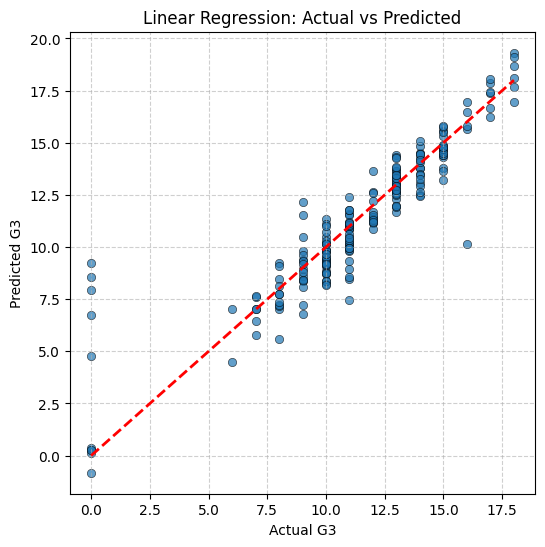

In [12]:
lin_pipe = build_and_evaluate(LinearRegression(), "Linear Regression")

  Lasso Regression: RMSE = 1.53 | R² = 0.822


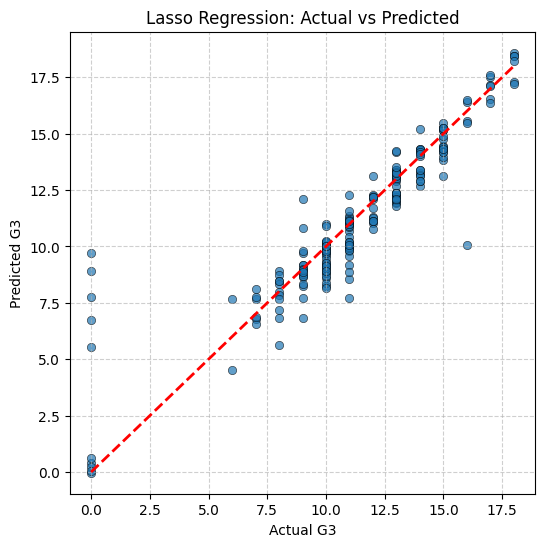

In [13]:
lasso_pipe = build_and_evaluate(Lasso(alpha=0.1, random_state=42), "Lasso Regression")

           LassoCV: RMSE = 1.52 | R² = 0.825


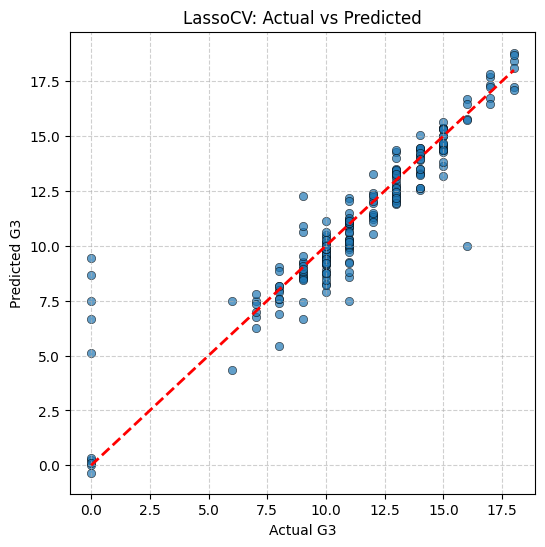

In [14]:
lasso_pipe = build_and_evaluate(
    LassoCV(alphas=np.logspace(-3, 3, 50), cv=5, random_state=42, max_iter=5000),
    "LassoCV"
)

  Ridge Regression: RMSE = 1.55 | R² = 0.820


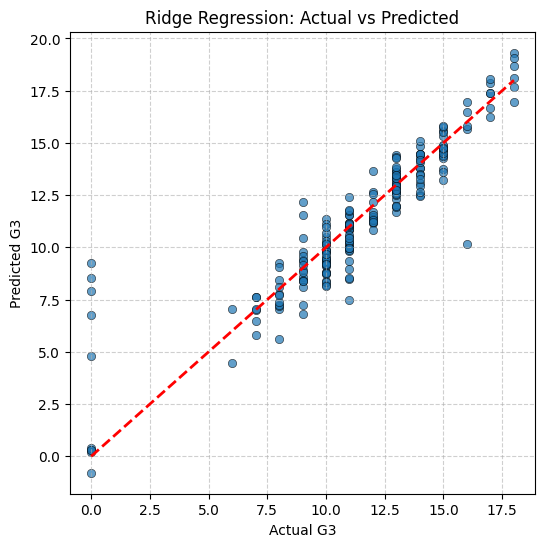

In [15]:
ridge_pipe  = build_and_evaluate(Ridge(alpha=1.0, random_state=42), "Ridge Regression")

           RidgeCV: RMSE = 1.55 | R² = 0.819


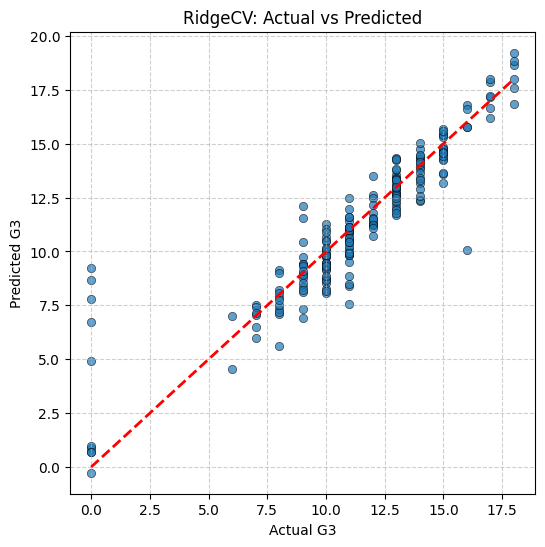

In [16]:
ridge_pipe = build_and_evaluate(
    RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5),
    "RidgeCV"
)

ElasticNet Regression: RMSE = 1.55 | R² = 0.818


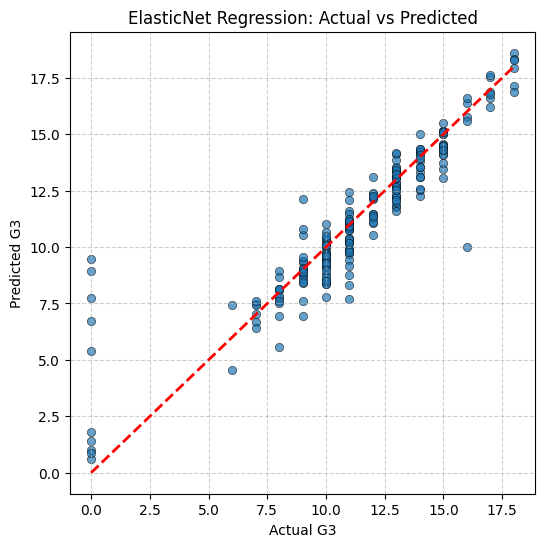

In [17]:
enet_pipe   = build_and_evaluate(ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42), "ElasticNet Regression")

      ElasticNetCV: RMSE = 1.52 | R² = 0.825


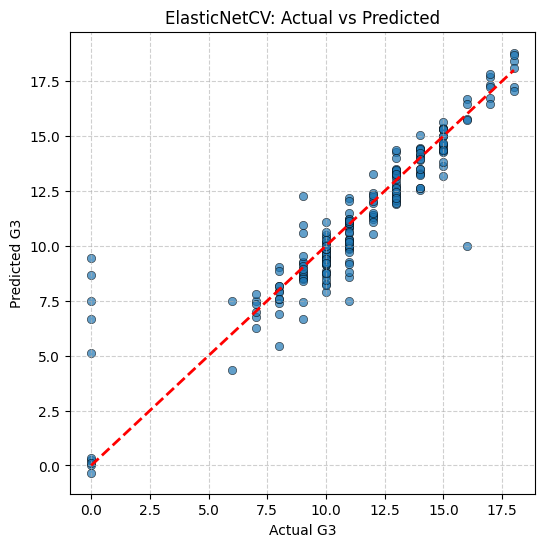

In [18]:
enet_pipe = build_and_evaluate(
    ElasticNetCV(alphas=np.logspace(-3, 3, 50), 
                 l1_ratio=[.1, .3, .5, .7, .9, .95, .99, 1],
                 cv=5,
                 random_state=42,
                 max_iter=5000),
    "ElasticNetCV"
)

### Model Comparison & Results

I tested multiple regression models (Linear, Ridge, Lasso, ElasticNet) to predict the final grade **G3**.  
All models performed similarly, with an average error of **~1.5 grade points** and explaining **~82% of the variance**.

- **Linear Regression**: RMSE = 1.55 | R² = 0.819  
- **LassoCV**: RMSE = 1.52 | R² = 0.825  
- **RidgeCV**: RMSE = 1.55 | R² = 0.819  
- **ElasticNetCV**: RMSE = 1.52 | R² = 0.825  

**Observations:**
- Regularization had little impact → dataset is already strong and predictive.  
- **LassoCV and ElasticNetCV** slightly outperformed others.  
- For interpretability (feature selection), **LassoCV** is the preferred choice.  
- For generalization, **ElasticNetCV** balances L1/L2 penalties.

### Final Decision: **Use LassoCV** as the main model due to best performance + feature selection ability.


# 9. Pickling

In [19]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'Medu', 'Fedu', 'traveltime',
                                  'studytime', 'failures', 'famrel', 'freetime',
                                  'goout', 'Dalc', 'Walc', 'health', 'absences',
                                  'G1', 'G2']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['school', 'sex', 'address', 'famsize',
                                  'Pstatus', 'Mjob', 'Fjob', 'reason',
                                  'guardian', 'schoolsup', 'famsup', 'paid',
                                  'activities', 'nursery', 'higher', 'internet',
                                  'romantic', 'subject'])])

In [21]:
lasso_pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'Medu', 'Fedu',
                                                   'traveltime', 'studytime',
                                                   'failures', 'famrel',
                                                   'freetime', 'goout', 'Dalc',
                                                   'Walc', 'health', 'absences',
                                                   'G1', 'G2']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['school', 'sex', 'address',
                                                   'famsize', 'Pstatus', 'Mjob',
                                                   'Fjob', 'reason', 'guardian',...
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
                         cv=5, max_iter=5000, random_state=42))])

In [ ]:
import pickle
from sklearn.pipeline import Pipeline

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),   
    ("model", lasso_pipe)             
])

with open("model/student_performance_pipeline.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)